In [4]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv networkx matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:0000:01
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=545106 sha256=48c7dbc0919b492c96c475a3de22cba888606e019f25336dc5556a026de4965e
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=1123745 sha256=3314b238ca765b79cc11ba5cc0cfbd7df1

In [29]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import subgraph

# Function to visualize subgraph
def visualize_subgraph(data, user_idx, item_idx, behavior, ax, max_nodes=100):
    """
    Visualizes a subgraph showing the relationship between a user and item with a specific behavior type (click/buy).
    
    :param data: HeteroData object containing the graph.
    :param user_idx: User index to analyze.
    :param item_idx: Item index to analyze.
    :param behavior: Behavior type (click or buy).
    :param ax: Matplotlib Axes object for visualization.
    :param max_nodes: Maximum number of nodes to display in the subgraph.
    """
    # Debugging: Check the unique behavior values
    print("Unique behavior values:", torch.unique(data['user', 'item'].behavior))
    
    # Filter edges based on behavior
    behavior_filter = data['user', 'item'].behavior == behavior
    selected_edges = data['user', 'item'].edge_index[:, behavior_filter]
    
    # Debugging: Print how many edges are being selected for the behavior
    print(f"Number of edges for behavior {behavior}: {selected_edges.shape[1]}")

    # Get nodes involved in the behavior
    nodes = torch.cat([selected_edges[0], selected_edges[1]])  # Collect all unique nodes from selected edges
    unique_nodes = torch.unique(nodes)

    # Debugging: Check how many unique nodes exist for the given behavior
    print(f"Number of unique nodes for behavior {behavior}: {len(unique_nodes)}")

    # Limit the number of nodes to visualize
    unique_nodes = unique_nodes[:min(len(unique_nodes), max_nodes)]  # Limit to max_nodes

    # Get the subgraph (with relabeling of nodes)
    edge_index_subgraph, _ = subgraph(unique_nodes, data['user', 'item'].edge_index, relabel_nodes=True)
    
    # Debugging: Check the subgraph structure
    print(f"Subgraph edge_index shape: {edge_index_subgraph.shape}")

    # Create a NetworkX graph
    G = nx.Graph()
    
    # Add edges to the NetworkX graph
    for i in range(edge_index_subgraph.shape[1]):
        u, v = edge_index_subgraph[0, i].item(), edge_index_subgraph[1, i].item()
        G.add_edge(u, v)
    
    # Use a layout for node positioning (e.g., Kamada-Kawai layout)
    pos = nx.spring_layout(G, iterations=10)  # Reduced iterations for faster computation
    
    # Draw the graph on the given axes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', ax=ax)
    ax.set_title(f"Behavior: {behavior}")

# Example usage
user_idx = 0  # Example user index
item_idx = 0  # Example item index

# Assuming data is loaded properly as HeteroData
data = torch.load('/kaggle/input/graph-dataset/processed_data.pt')  # Without weights_only=True

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Visualize click (behavior=0) with a limited number of nodes
visualize_subgraph(data, user_idx, item_idx, behavior=0, ax=ax[0], max_nodes=100)

# Visualize buy (behavior=2) with a limited number of nodes
visualize_subgraph(data, user_idx, item_idx, behavior=2, ax=ax[1], max_nodes=100)

plt.show()

Total purchase edges: 101182
Top users by purchase count: [(42101, 175), (36725, 62), (28139, 60), (43962, 56), (35170, 52)]
Graph has 89 nodes and 84 edges


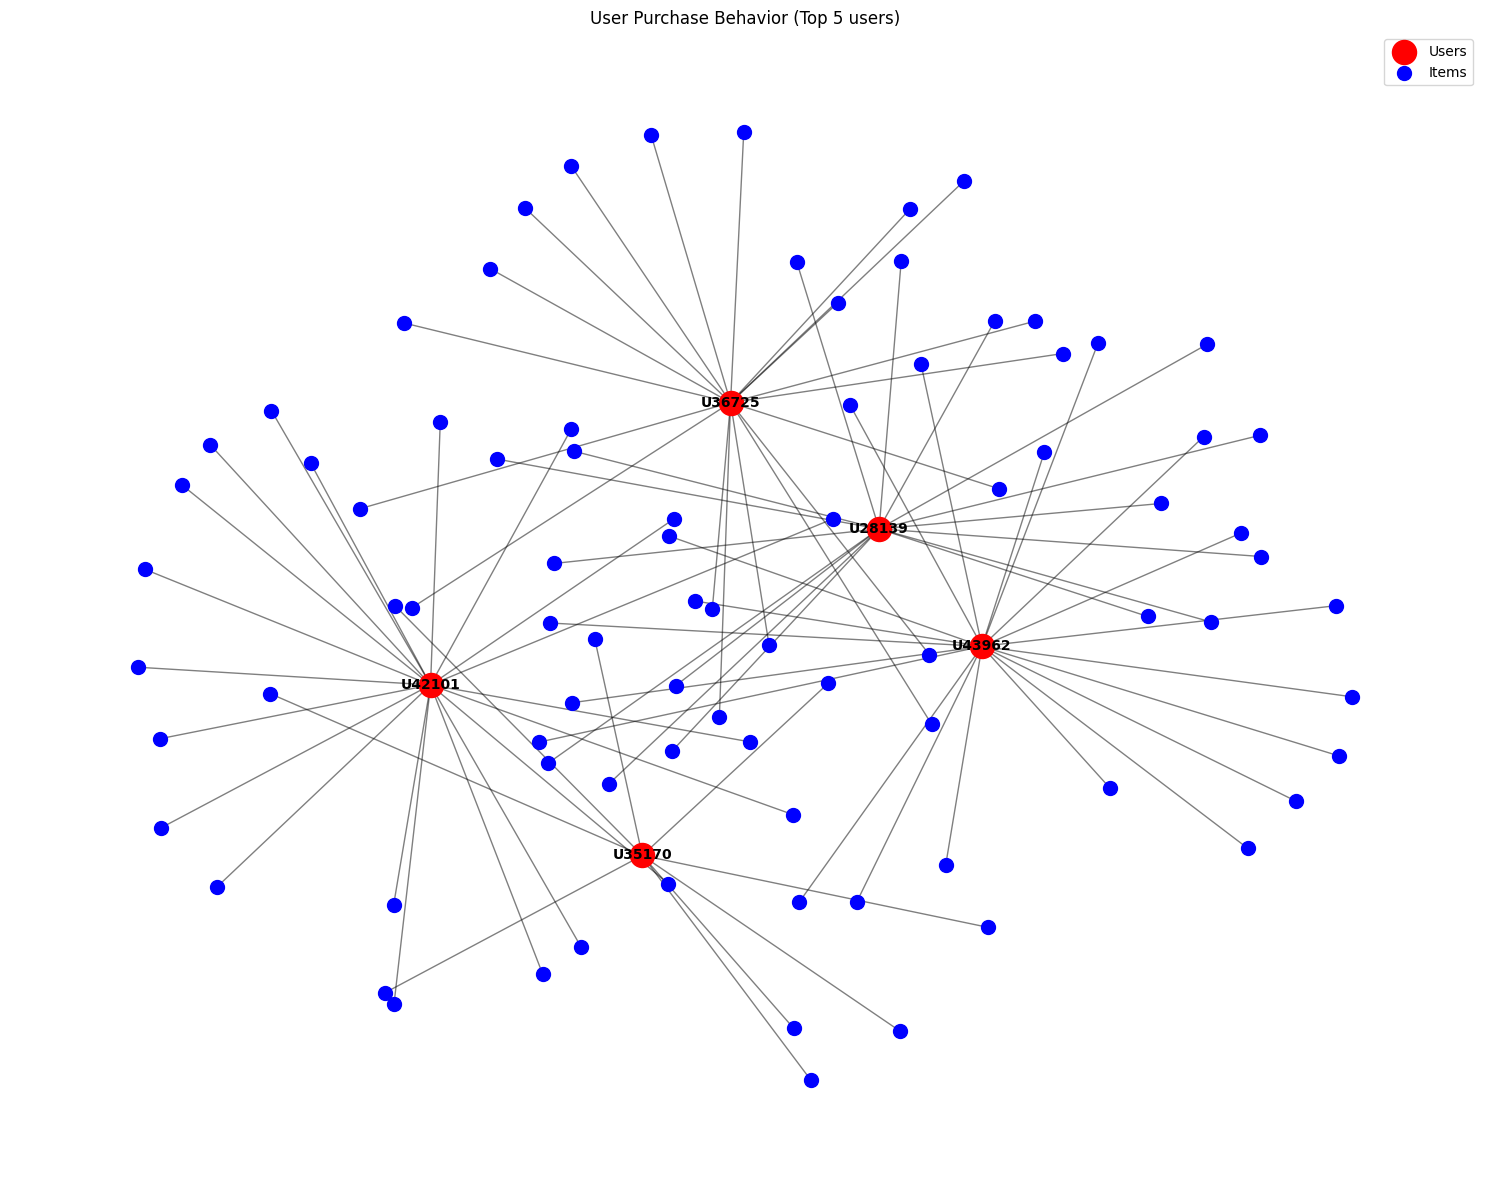

In [37]:
def visualize_user_purchases(data, num_users=5, ax=None, behavior=2, max_items_per_user=20):
    """
    Visualizes a subgraph focused on specific users and their purchased items.
    
    :param data: HeteroData object containing the graph
    :param num_users: Number of users to visualize
    :param ax: Matplotlib axes for plotting
    :param behavior: Behavior type (2 for purchases)
    :param max_items_per_user: Maximum number of items to show per user
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 10))
    
    # Filter edges for the specified behavior (purchases)
    behavior_filter = data['user', 'item'].behavior == behavior
    purchase_edges = data['user', 'item'].edge_index[:, behavior_filter]
    
    print(f"Total purchase edges: {purchase_edges.shape[1]}")
    
    # Find users with the most purchases
    user_counts = {}
    for i in range(purchase_edges.shape[1]):
        user = purchase_edges[0, i].item()
        user_counts[user] = user_counts.get(user, 0) + 1
    
    # Sort users by purchase count and take top ones
    top_users = sorted(user_counts.items(), key=lambda x: x[1], reverse=True)[:num_users]
    top_user_ids = [user for user, count in top_users]
    
    print(f"Top users by purchase count: {top_users}")
    
    # Create a NetworkX graph
    G = nx.Graph()
    
    # For each top user, add their purchased items
    for user_id in top_user_ids:
        user_mask = purchase_edges[0] == user_id
        user_purchases = purchase_edges[:, user_mask]
        
        # Limit the number of items per user to avoid clutter
        item_limit = min(max_items_per_user, user_purchases.shape[1])
        for i in range(item_limit):
            item_id = user_purchases[1, i].item()
            G.add_edge(f"U{user_id}", f"I{item_id}")
    
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Use a different layout for better visualization of the purchase patterns
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
    # Draw with different colors and sizes for users and items
    user_nodes = [n for n in G.nodes() if n.startswith("U")]
    item_nodes = [n for n in G.nodes() if n.startswith("I")]
    
    nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='red', 
                          node_size=300, label='Users', ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_color='blue', 
                          node_size=100, label='Items', ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax)
    
    # Label the user nodes (but not items to reduce clutter)
    user_labels = {node: node for node in user_nodes}
    nx.draw_networkx_labels(G, pos, labels=user_labels, font_size=10, font_weight='bold', ax=ax)
    
    ax.set_title(f"User Purchase Behavior (Top {num_users} users)")
    ax.legend()
    ax.axis('off')
    
    return G

# Create a figure
fig, ax = plt.subplots(figsize=(15, 12))

# Visualize top users and their purchases
G = visualize_user_purchases(data, num_users=5, ax=ax, behavior=2, max_items_per_user=20)

plt.tight_layout()
plt.savefig('user_purchases.png')
plt.show()

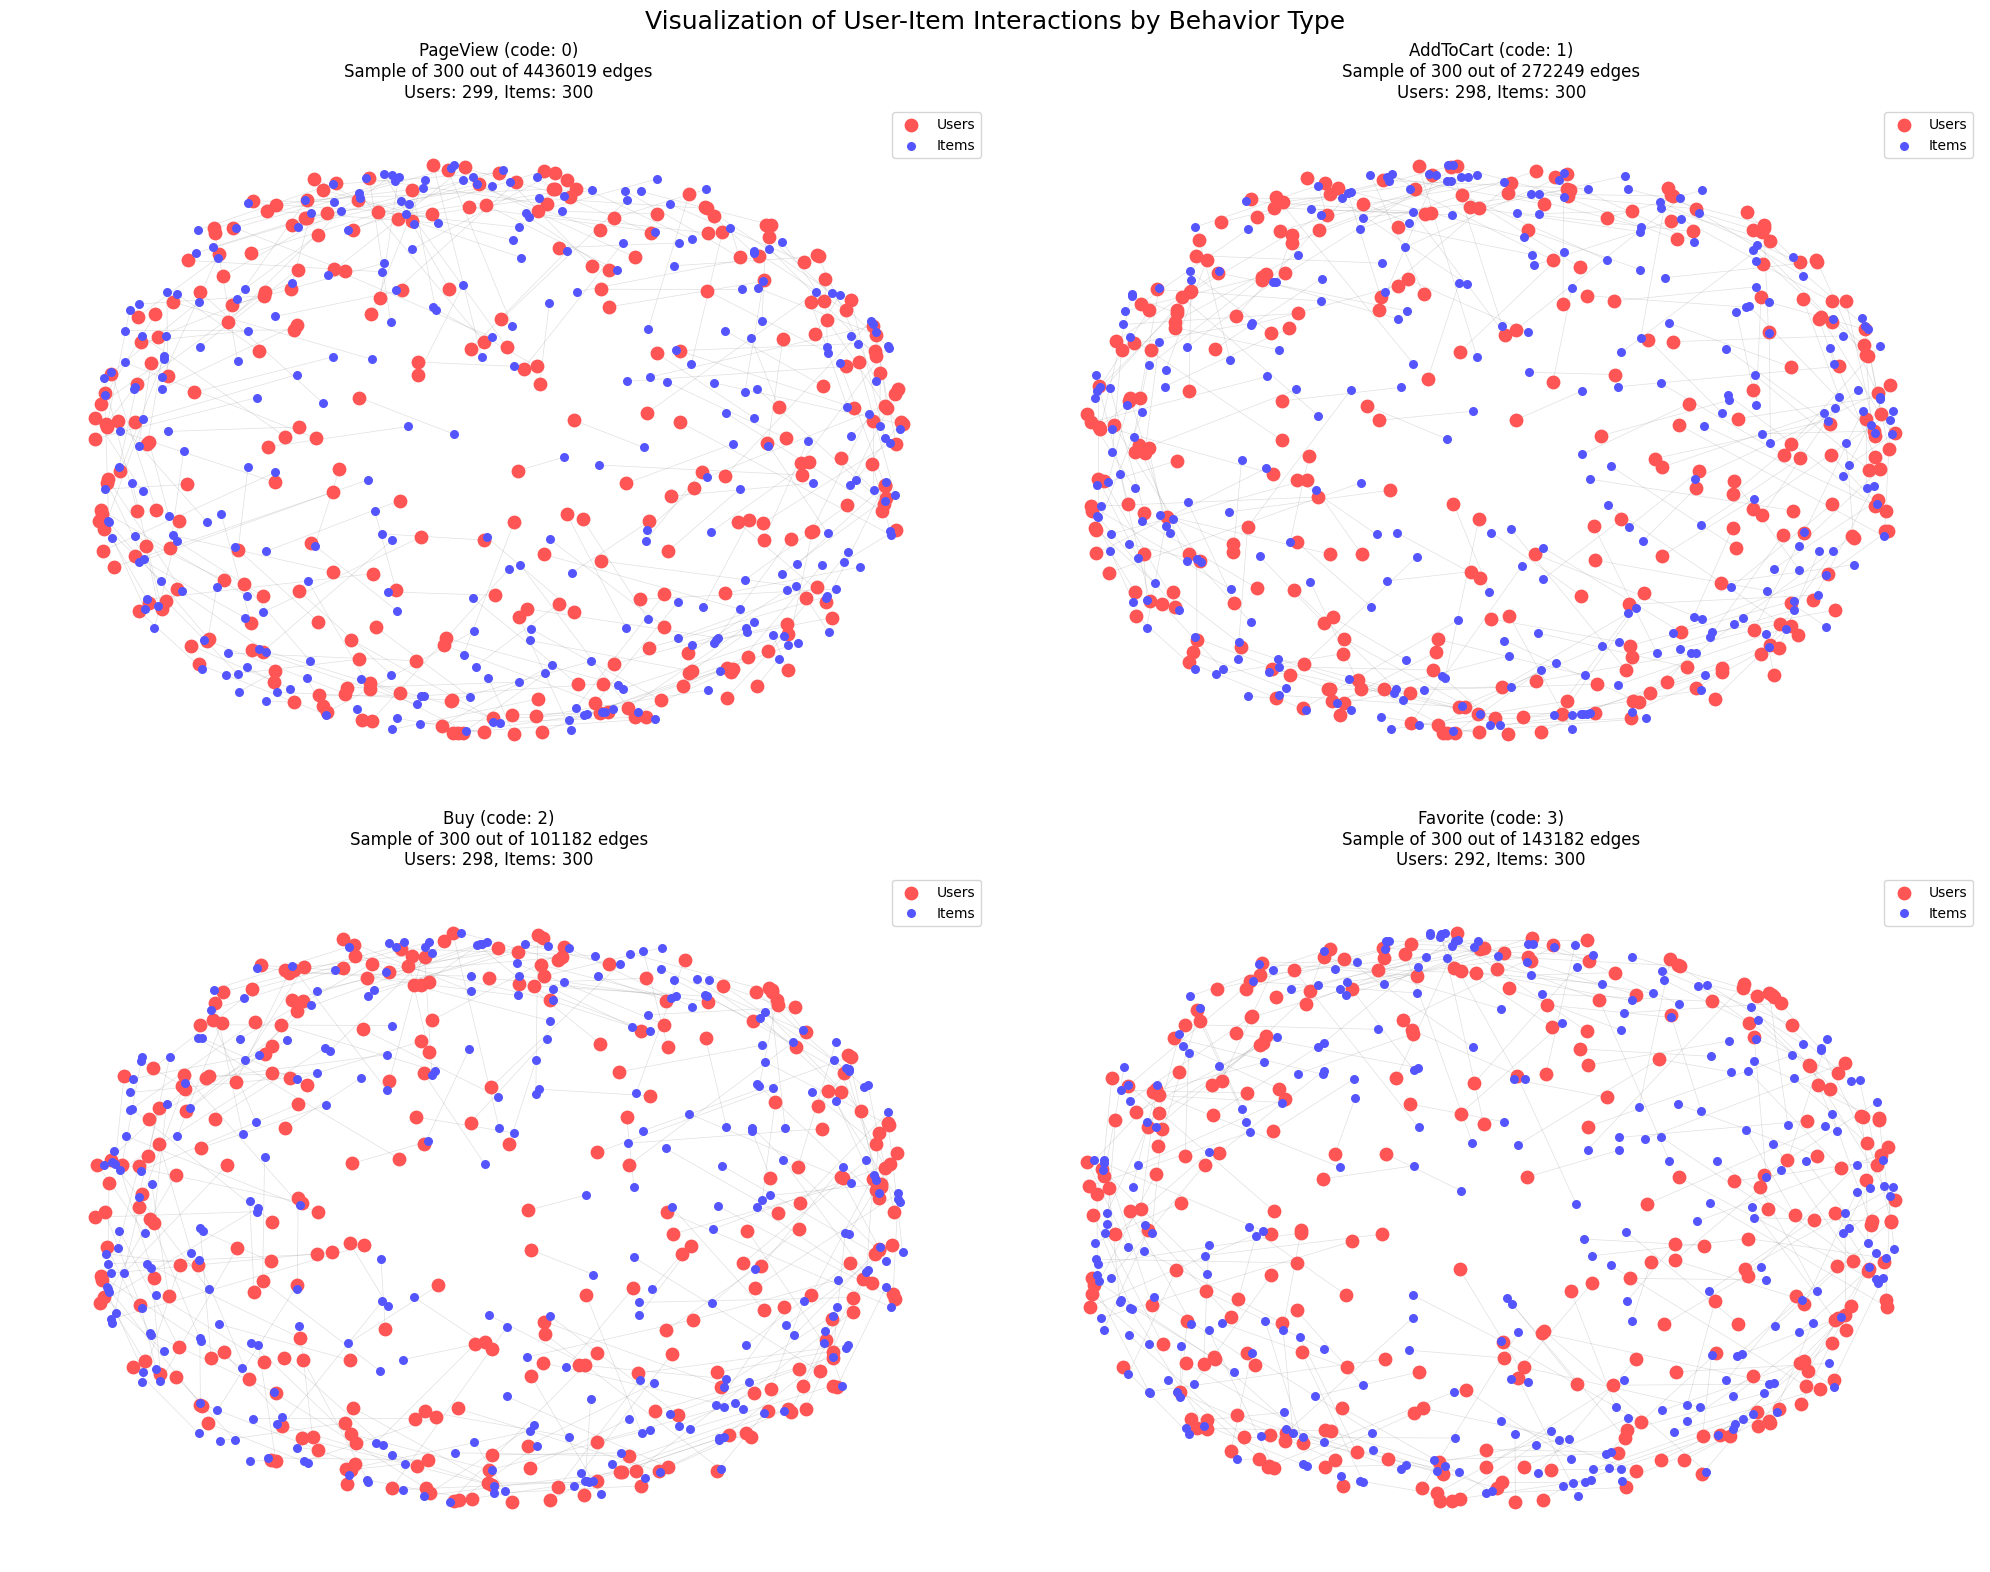


Dataset Statistics:
--------------------------------------------------
Total unique users: 49400
Total unique items: 1099089
Total interactions: 4952632
--------------------------------------------------
PageView: 4436019 interactions (89.57%)
AddToCart: 272249 interactions (5.50%)
Buy: 101182 interactions (2.04%)
Favorite: 143182 interactions (2.89%)
--------------------------------------------------
Average interactions per user: 100.26
Average interactions per item: 4.51


In [38]:
def visualize_behavior_patterns(data, behaviors_dict, sample_size=200, seed=42):
    """
    Creates a comprehensive visualization of the dataset with different behaviors.
    
    :param data: HeteroData object containing the graph
    :param behaviors_dict: Dictionary mapping behavior names to their numeric codes
    :param sample_size: Number of edges to sample for each behavior
    :param seed: Random seed for reproducibility
    """
    # Invert the behavior dictionary for displaying names
    behavior_names = {v: k for k, v in behaviors_dict.items()}
    
    # Create a figure with subplots for each behavior
    num_behaviors = len(behaviors_dict)
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    
    # Process each behavior type
    for behavior_idx, (behavior_name, behavior_code) in enumerate(behaviors_dict.items()):
        ax = axes[behavior_idx]
        
        # Filter edges for this behavior
        behavior_filter = data['user', 'item'].behavior == behavior_code
        behavior_edges = data['user', 'item'].edge_index[:, behavior_filter]
        
        # Count total edges for this behavior
        total_edges = behavior_edges.shape[1]
        
        # Sample a subset of edges for visualization
        if total_edges > sample_size:
            # Random sampling
            indices = torch.randperm(total_edges)[:sample_size]
            sampled_edges = behavior_edges[:, indices]
        else:
            sampled_edges = behavior_edges
        
        # Create NetworkX graph
        G = nx.Graph()
        
        # Add edges to the graph
        for i in range(sampled_edges.shape[1]):
            user_id = sampled_edges[0, i].item()
            item_id = sampled_edges[1, i].item()
            G.add_edge(f"U{user_id}", f"I{item_id}")
        
        # Calculate some graph statistics
        num_users = len([n for n in G.nodes() if n.startswith("U")])
        num_items = len([n for n in G.nodes() if n.startswith("I")])
        
        # Use a force-directed layout
        pos = nx.spring_layout(G, k=0.3, iterations=50, seed=seed)
        
        # Draw with different colors and sizes
        user_nodes = [n for n in G.nodes() if n.startswith("U")]
        item_nodes = [n for n in G.nodes() if n.startswith("I")]
        
        nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='#FF5555', 
                              node_size=80, label='Users', ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_color='#5555FF', 
                              node_size=30, label='Items', ax=ax)
        nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, edge_color='#999999', ax=ax)
        
        # Add title with statistics
        ax.set_title(f"{behavior_name} (code: {behavior_code})\n"
                    f"Sample of {sampled_edges.shape[1]} out of {total_edges} edges\n"
                    f"Users: {num_users}, Items: {num_items}", fontsize=12)
        
        ax.legend(fontsize=10)
        ax.axis('off')
    
    plt.suptitle("Visualization of User-Item Interactions by Behavior Type", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    # Save the figure
    plt.savefig('behavior_patterns.png', dpi=300)
    plt.show()
    
    # Print additional dataset statistics
    print("\nDataset Statistics:")
    print("-" * 50)
    
    edge_index = data['user', 'item'].edge_index
    behaviors = data['user', 'item'].behavior
    
    total_users = len(torch.unique(edge_index[0]))
    total_items = len(torch.unique(edge_index[1]))
    total_edges = edge_index.shape[1]
    
    print(f"Total unique users: {total_users}")
    print(f"Total unique items: {total_items}")
    print(f"Total interactions: {total_edges}")
    print("-" * 50)
    
    # Behavior distribution
    for behavior_name, behavior_code in behaviors_dict.items():
        count = (behaviors == behavior_code).sum().item()
        percentage = (count / total_edges) * 100
        print(f"{behavior_name}: {count} interactions ({percentage:.2f}%)")
    
    print("-" * 50)
    
    # Calculate average interactions per user and item
    print(f"Average interactions per user: {total_edges / total_users:.2f}")
    print(f"Average interactions per item: {total_edges / total_items:.2f}")

# Define the behavior dictionary
behavior_dict = {'PageView': 0, 'AddToCart': 1, 'Buy': 2, 'Favorite': 3}

# Run the visualization
visualize_behavior_patterns(data, behavior_dict, sample_size=300)

Selected user ID: 2 (has all behavior types)


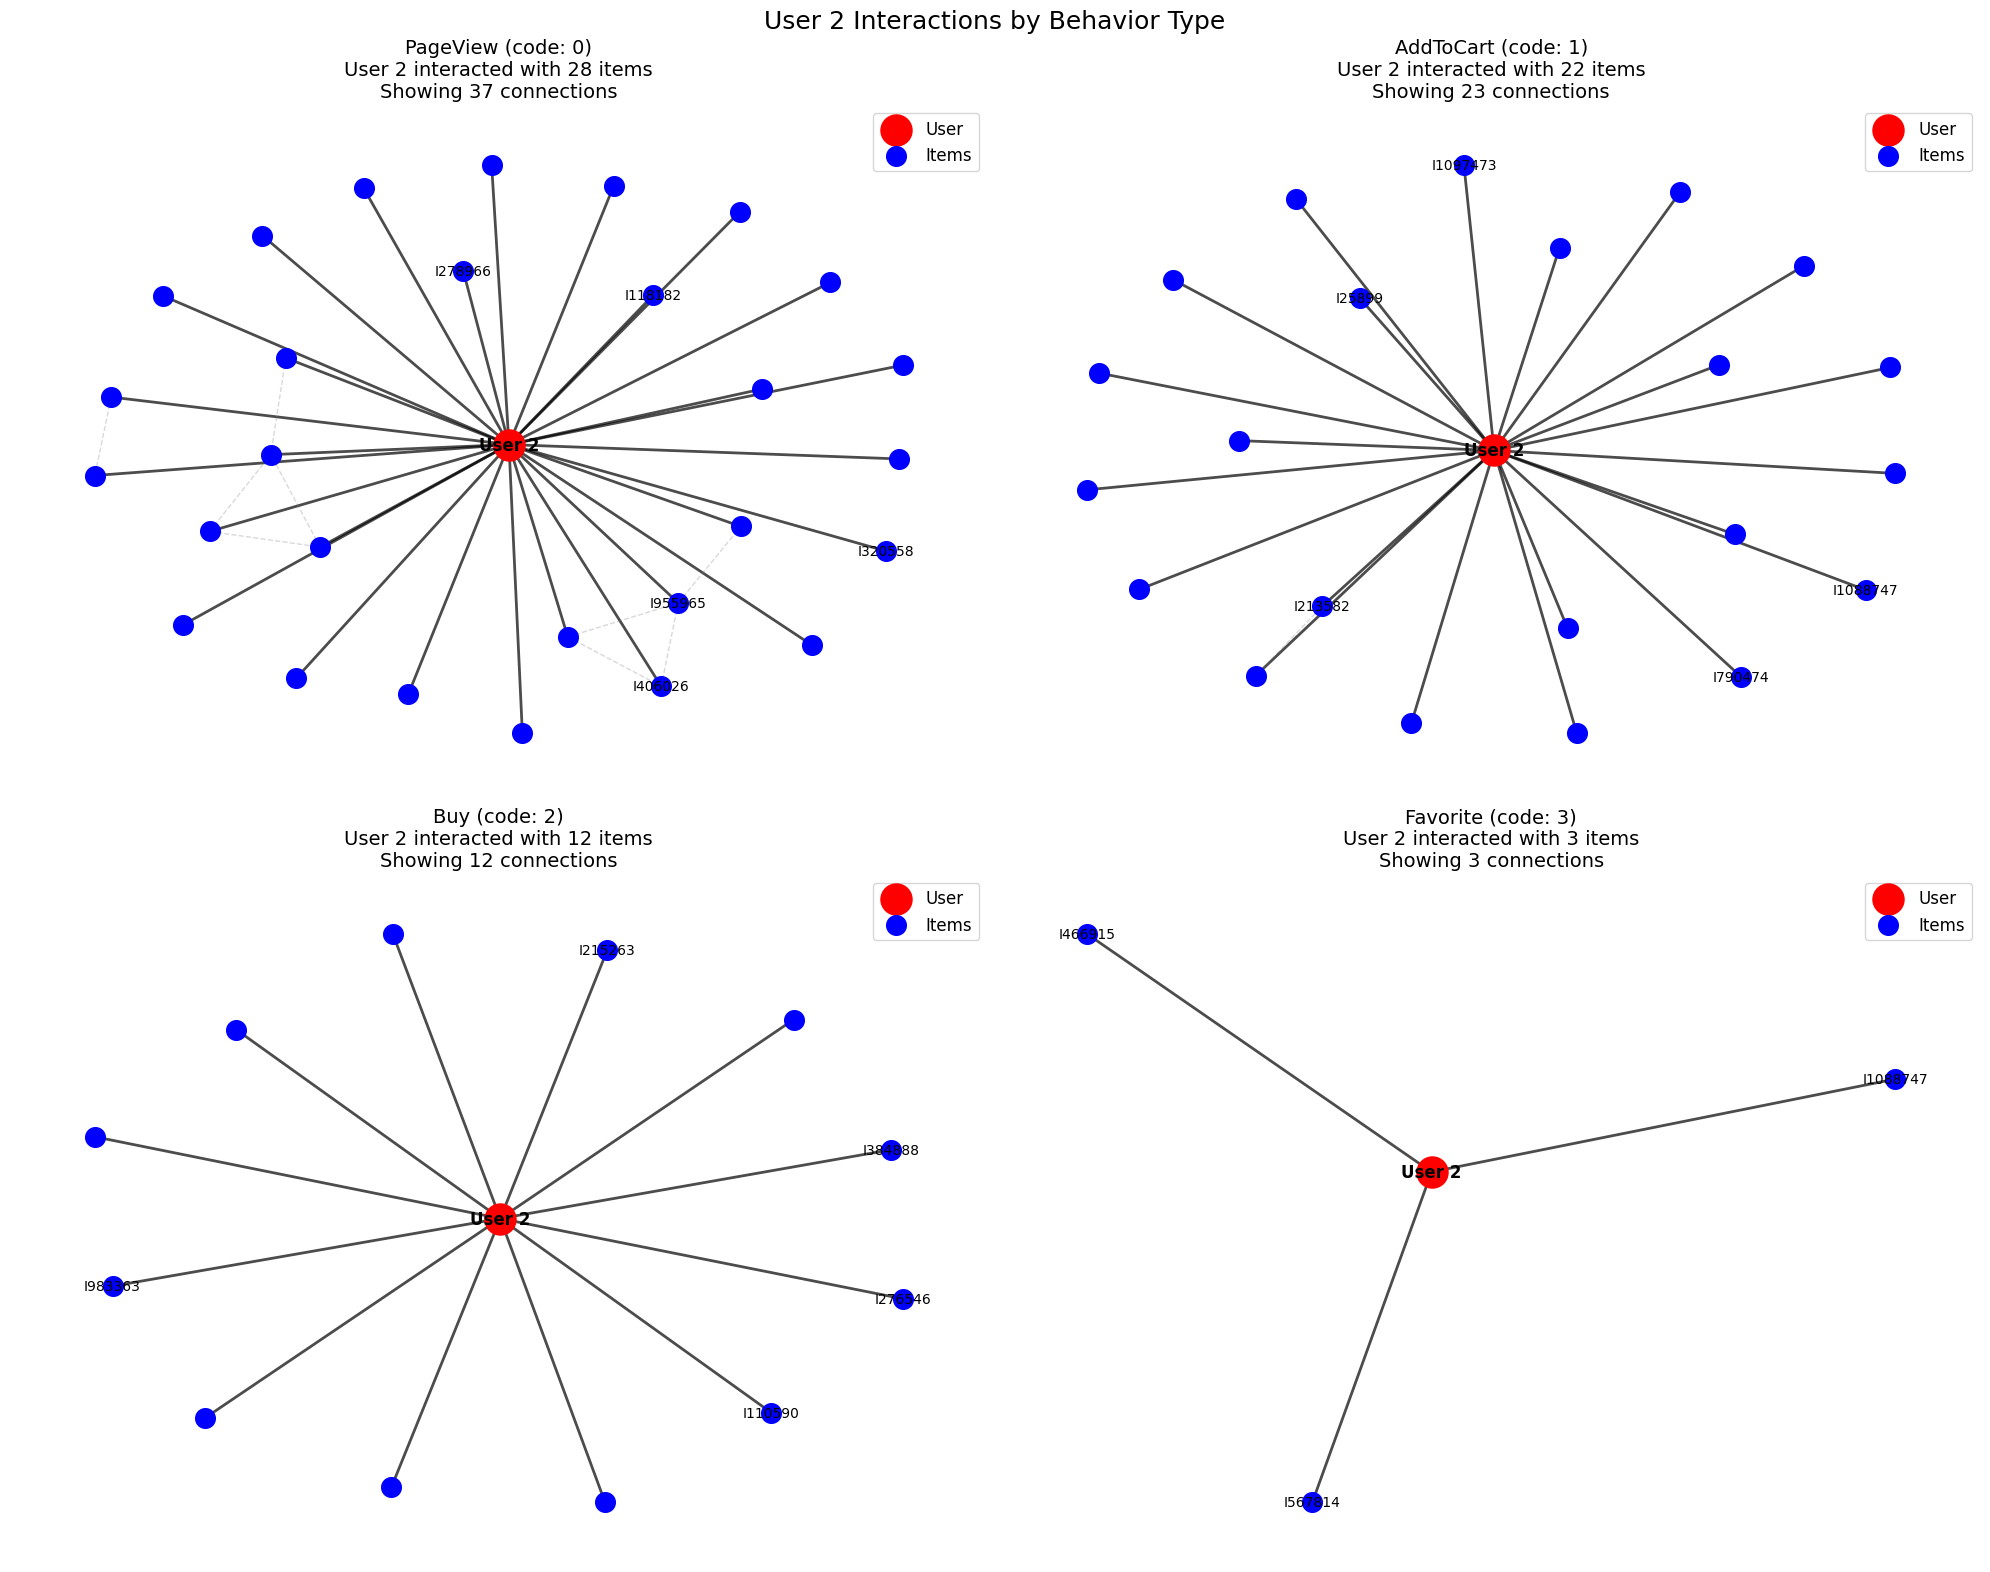

In [39]:
def visualize_user_behavior_subgraphs(data, behaviors_dict, user_id=None, max_items=30):
    """
    Visualizes subgraphs centered around a specific user for each behavior type.
    
    :param data: HeteroData object containing the graph
    :param behaviors_dict: Dictionary mapping behavior names to their numeric codes
    :param user_id: User ID to focus on. If None, will select a user with all behavior types.
    :param max_items: Maximum number of items to display per behavior
    """
    # Invert the behavior dictionary for displaying names
    behavior_names = {v: k for k, v in behaviors_dict.items()}
    
    # If no user_id is provided, find a user that has all behavior types
    if user_id is None:
        user_candidates = []
        all_users = torch.unique(data['user', 'item'].edge_index[0]).tolist()
        
        # For each user, check if they have all behaviors
        for user in all_users[:1000]:  # Check first 1000 users for efficiency
            has_all_behaviors = True
            for behavior_code in behaviors_dict.values():
                user_mask = (data['user', 'item'].edge_index[0] == user) & (data['user', 'item'].behavior == behavior_code)
                if user_mask.sum() == 0:
                    has_all_behaviors = False
                    break
            
            if has_all_behaviors:
                user_candidates.append(user)
                if len(user_candidates) >= 5:  # Stop after finding 5 candidates
                    break
        
        if user_candidates:
            user_id = user_candidates[0]
            print(f"Selected user ID: {user_id} (has all behavior types)")
        else:
            # If no user has all behaviors, pick one with the most behaviors
            user_id = all_users[0]
            print(f"No user with all behaviors found. Selected user ID: {user_id}")
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    # Process each behavior type
    for behavior_idx, (behavior_name, behavior_code) in enumerate(behaviors_dict.items()):
        ax = axes[behavior_idx]
        
        # Filter edges for this user and behavior
        user_behavior_mask = (data['user', 'item'].edge_index[0] == user_id) & (data['user', 'item'].behavior == behavior_code)
        user_edges = data['user', 'item'].edge_index[:, user_behavior_mask]
        
        # Count total edges for this user and behavior
        total_user_edges = user_edges.shape[1]
        
        if total_user_edges == 0:
            ax.text(0.5, 0.5, f"No {behavior_name} interactions for user {user_id}", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14)
            ax.axis('off')
            continue
        
        # Limit the number of items
        if total_user_edges > max_items:
            user_edges = user_edges[:, :max_items]
        
        # Create NetworkX graph
        G = nx.Graph()
        
        # Add the central user node
        user_node = f"U{user_id}"
        G.add_node(user_node)
        
        # Add edges to items
        for i in range(user_edges.shape[1]):
            item_id = user_edges[1, i].item()
            item_node = f"I{item_id}"
            G.add_edge(user_node, item_node)
        
        # For a more interesting view, also add some connections between items
        # Find items that are connected to the same users (co-occurrence)
        item_ids = [user_edges[1, i].item() for i in range(user_edges.shape[1])]
        
        for item1 in item_ids:
            for item2 in item_ids:
                if item1 != item2:
                    # Find if these items have common users other than our focus user
                    item1_mask = data['user', 'item'].edge_index[1] == item1
                    item2_mask = data['user', 'item'].edge_index[1] == item2
                    users1 = set(data['user', 'item'].edge_index[0, item1_mask].tolist())
                    users2 = set(data['user', 'item'].edge_index[0, item2_mask].tolist())
                    common_users = users1.intersection(users2)
                    
                    # Add an edge between items if they have common users (with low probability to reduce clutter)
                    if len(common_users) > 1 and random.random() < 0.1:
                        G.add_edge(f"I{item1}", f"I{item2}")
        
        # Use a star layout to emphasize the central user
        pos = nx.spring_layout(G, k=0.4, iterations=50, seed=42)
        
        # Draw with different colors and sizes
        user_nodes = [n for n in G.nodes() if n.startswith("U")]
        item_nodes = [n for n in G.nodes() if n.startswith("I")]
        
        nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='red', 
                              node_size=500, label='User', ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_color='blue', 
                              node_size=200, label='Items', ax=ax)
        
        # Draw edges with different styles based on connection type
        user_item_edges = [(u, v) for u, v in G.edges() if (u.startswith("U") and v.startswith("I")) or 
                           (u.startswith("I") and v.startswith("U"))]
        item_item_edges = [(u, v) for u, v in G.edges() if u.startswith("I") and v.startswith("I")]
        
        nx.draw_networkx_edges(G, pos, edgelist=user_item_edges, width=2.0, alpha=0.7, 
                              edge_color='black', ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=item_item_edges, width=1.0, alpha=0.3, 
                              edge_color='gray', style='dashed', ax=ax)
        
        # Add labels to nodes
        nx.draw_networkx_labels(G, pos, {user_node: f"User {user_id}"}, font_size=12, 
                               font_weight='bold', ax=ax)
        
        # Item labels - only show a few to avoid clutter
        item_labels = {node: node for node in random.sample(item_nodes, min(5, len(item_nodes)))}
        nx.draw_networkx_labels(G, pos, item_labels, font_size=10, ax=ax)
        
        # Add title with statistics
        ax.set_title(f"{behavior_name} (code: {behavior_code})\n"
                    f"User {user_id} interacted with {len(item_nodes)} items\n"
                    f"Showing {G.number_of_edges()} connections", fontsize=14)
        
        ax.legend(fontsize=12)
        ax.axis('off')
    
    plt.suptitle(f"User {user_id} Interactions by Behavior Type", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    # Save the figure
    plt.savefig('user_behavior_subgraphs.png', dpi=300)
    plt.show()

# Define the behavior dictionary
behavior_dict = {'PageView': 0, 'AddToCart': 1, 'Buy': 2, 'Favorite': 3}

# Import random for the visualization
import random

# Run the visualization
visualize_user_behavior_subgraphs(data, behavior_dict)

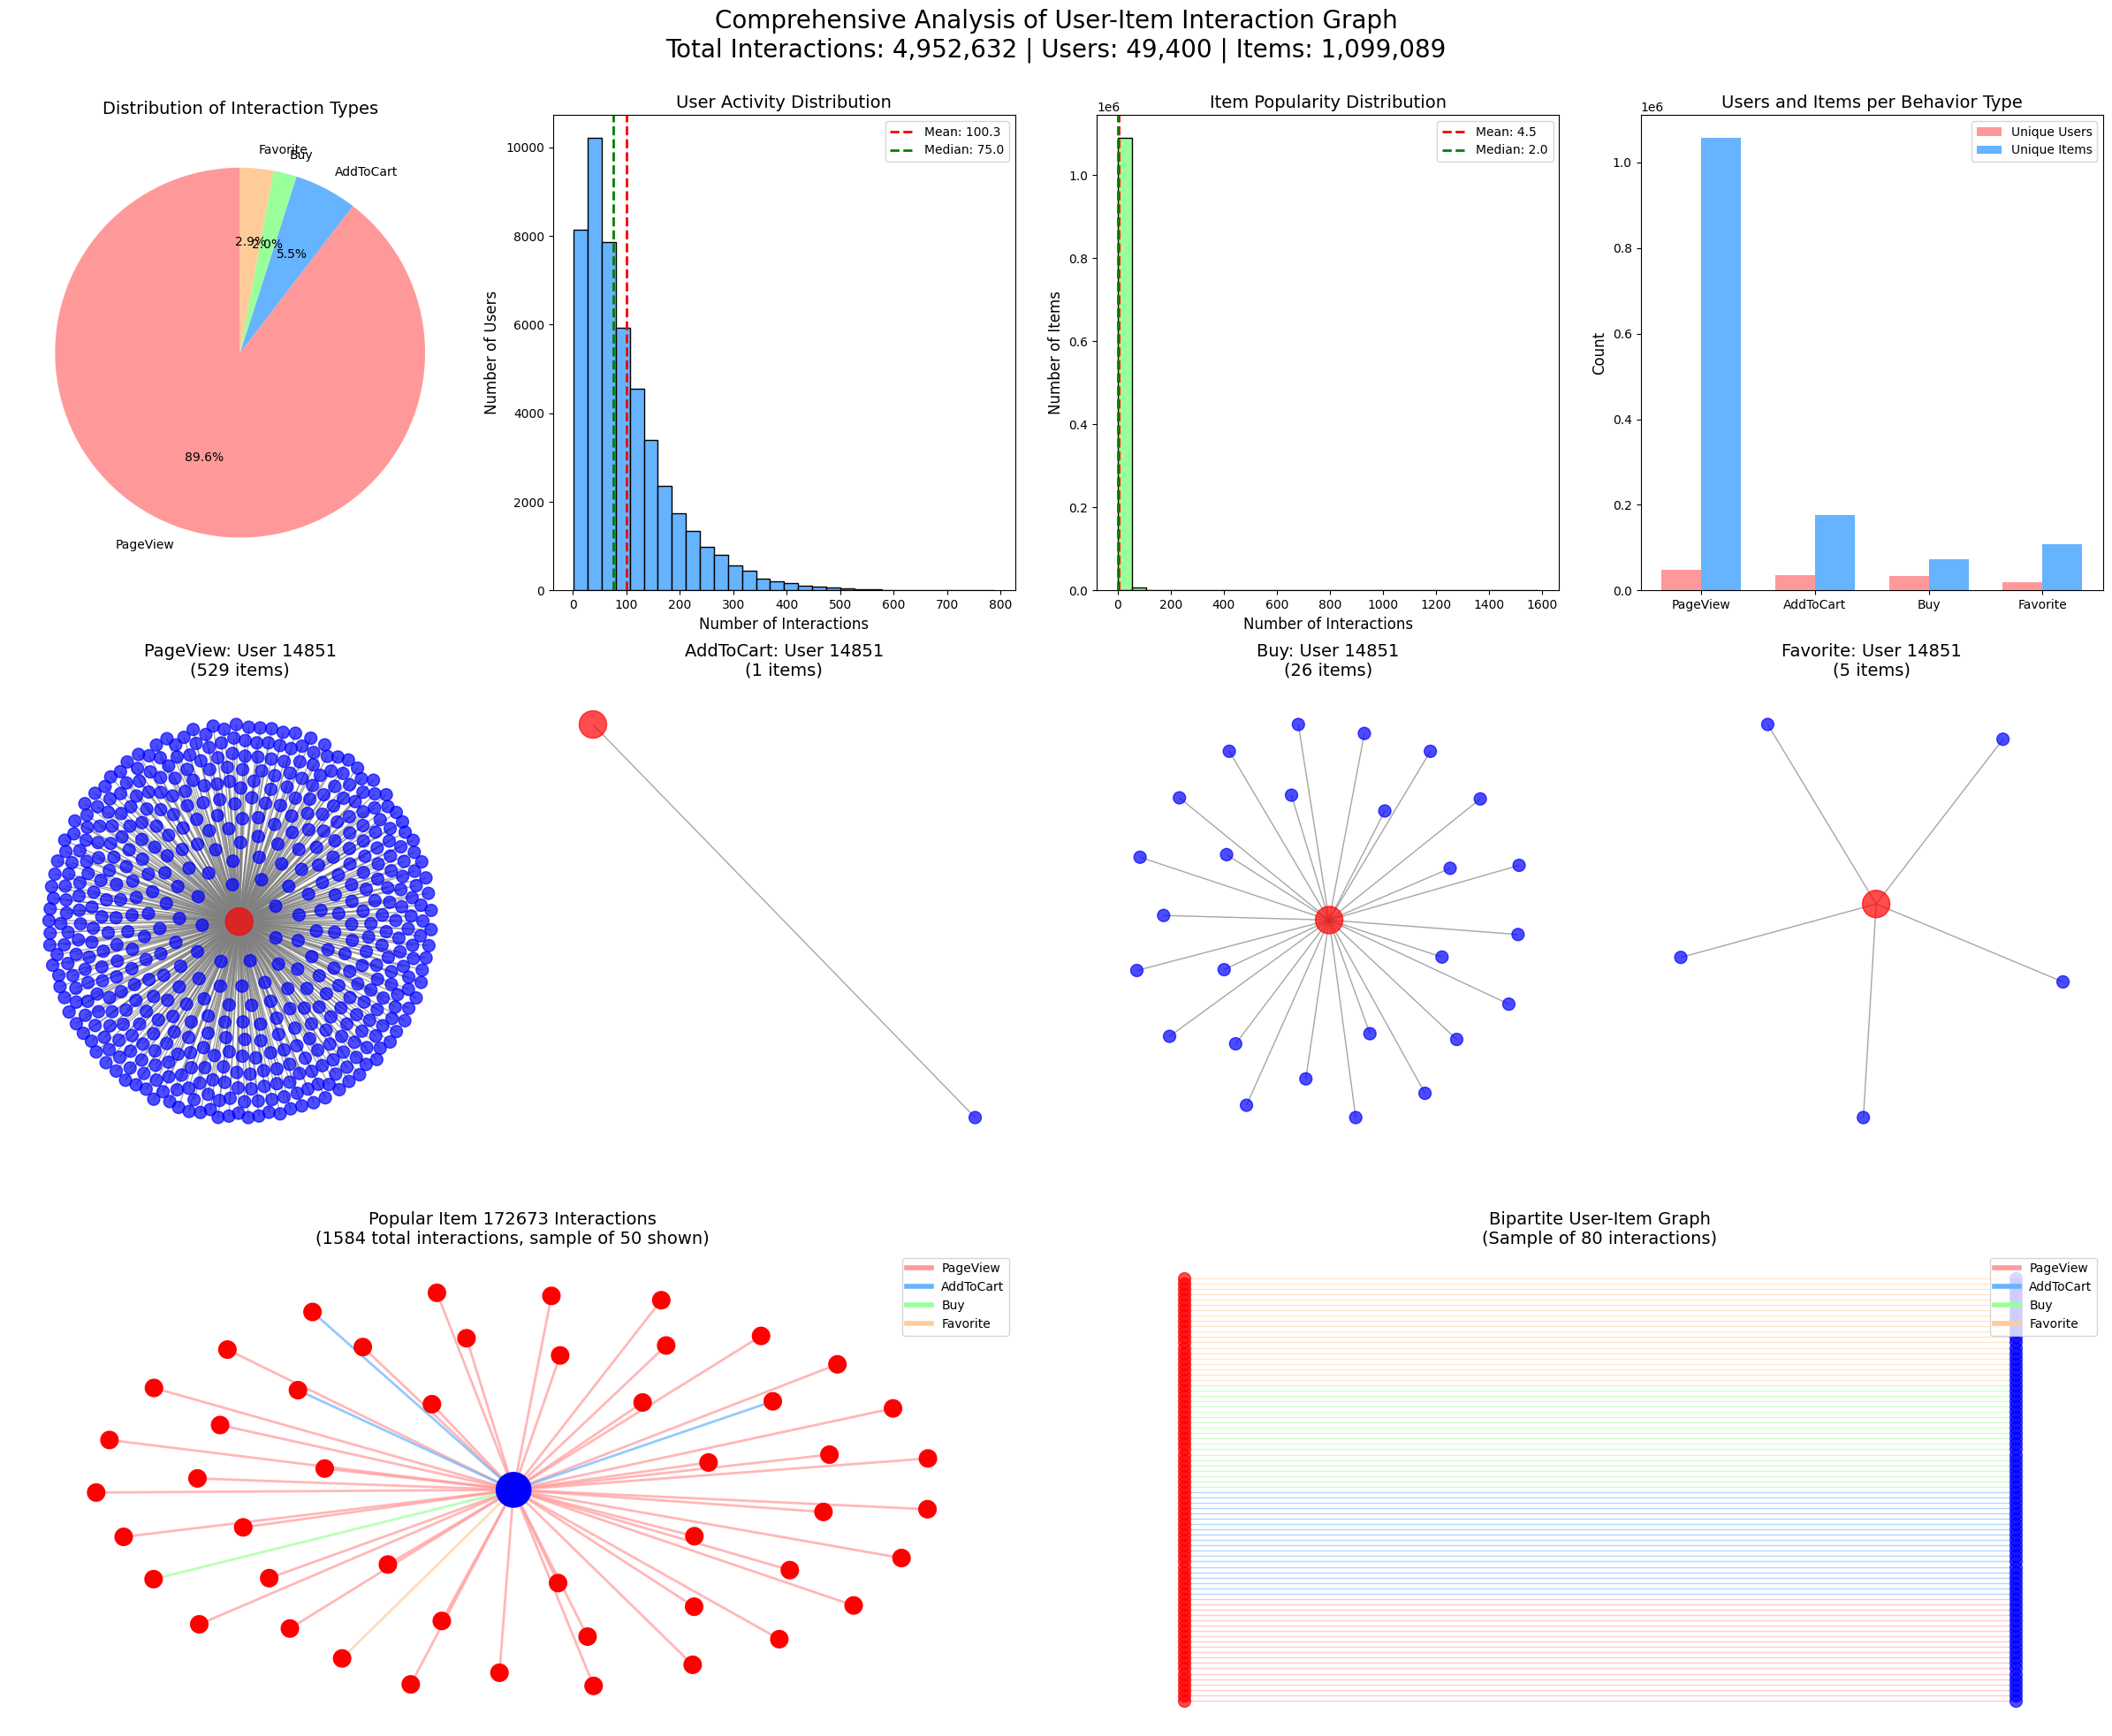


===== DATASET INSIGHTS =====
Total interactions: 4,952,632
Unique users: 49,400
Unique items: 1,099,089

Behavior distribution:
  - PageView: 4,436,019 interactions (89.57%)
  - AddToCart: 272,249 interactions (5.50%)
  - Buy: 101,182 interactions (2.04%)
  - Favorite: 143,182 interactions (2.89%)

User engagement statistics:
  - Average interactions per user: 100.26
  - Median interactions per user: 75.00
  - Most active user: 37134 with 788 interactions

Item popularity statistics:
  - Average interactions per item: 4.51
  - Median interactions per item: 2.00
  - Most popular item: 172673 with 1,584 interactions


In [40]:
def comprehensive_graph_analysis(data, behaviors_dict, random_seed=42):
    """
    Creates a comprehensive multi-panel visualization to understand dataset structure.
    
    :param data: HeteroData object containing the graph
    :param behaviors_dict: Dictionary mapping behavior names to their numeric codes
    :param random_seed: Random seed for reproducibility
    """
    # Invert the behavior dictionary for displaying names
    behavior_names = {v: k for k, v in behaviors_dict.items()}
    
    # Set random seeds for reproducibility
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    
    # Create a figure with subplots organized in panels
    fig = plt.figure(figsize=(24, 20))
    gs = gridspec.GridSpec(3, 4, figure=fig)
    
    # Get basic dataset statistics
    edge_index = data['user', 'item'].edge_index
    behaviors = data['user', 'item'].behavior
    
    total_users = len(torch.unique(edge_index[0]))
    total_items = len(torch.unique(edge_index[1]))
    total_edges = edge_index.shape[1]
    
    # 1. PANEL 1: Behavior Distribution (top-left)
    ax1 = fig.add_subplot(gs[0, 0])
    behavior_counts = []
    behavior_labels = []
    
    for behavior_name, behavior_code in behaviors_dict.items():
        count = (behaviors == behavior_code).sum().item()
        behavior_counts.append(count)
        behavior_labels.append(behavior_name)
    
    # Create a pie chart
    ax1.pie(behavior_counts, labels=behavior_labels, autopct='%1.1f%%', 
           colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'], startangle=90)
    ax1.set_title('Distribution of Interaction Types', fontsize=14)
    
    # 2. PANEL 2: User Activity Distribution (top-middle left)
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Count interactions per user
    user_counts = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0, i].item()
        user_counts[user] = user_counts.get(user, 0) + 1
    
    # Create histogram of user activity
    counts = list(user_counts.values())
    ax2.hist(counts, bins=30, color='#66b3ff', edgecolor='black')
    ax2.set_xlabel('Number of Interactions', fontsize=12)
    ax2.set_ylabel('Number of Users', fontsize=12)
    ax2.set_title('User Activity Distribution', fontsize=14)
    
    # Add some statistics
    avg_count = np.mean(counts)
    median_count = np.median(counts)
    ax2.axvline(avg_count, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {avg_count:.1f}')
    ax2.axvline(median_count, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_count:.1f}')
    ax2.legend()
    
    # 3. PANEL 3: Item Popularity Distribution (top-middle right)
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Count interactions per item
    item_counts = {}
    for i in range(edge_index.shape[1]):
        item = edge_index[1, i].item()
        item_counts[item] = item_counts.get(item, 0) + 1
    
    # Create histogram of item popularity
    counts = list(item_counts.values())
    ax3.hist(counts, bins=30, color='#99ff99', edgecolor='black')
    ax3.set_xlabel('Number of Interactions', fontsize=12)
    ax3.set_ylabel('Number of Items', fontsize=12)
    ax3.set_title('Item Popularity Distribution', fontsize=14)
    
    # Add some statistics
    avg_count = np.mean(counts)
    median_count = np.median(counts)
    ax3.axvline(avg_count, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {avg_count:.1f}')
    ax3.axvline(median_count, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_count:.1f}')
    ax3.legend()
    
    # 4. PANEL 4: Behavior Comparison (top-right)
    ax4 = fig.add_subplot(gs[0, 3])
    
    # Compare user count per behavior
    user_per_behavior = []
    item_per_behavior = []
    
    for behavior_code in behaviors_dict.values():
        behavior_mask = behaviors == behavior_code
        behavior_edges = edge_index[:, behavior_mask]
        unique_users = len(torch.unique(behavior_edges[0]))
        unique_items = len(torch.unique(behavior_edges[1]))
        user_per_behavior.append(unique_users)
        item_per_behavior.append(unique_items)
    
    # Create a grouped bar chart
    x = np.arange(len(behavior_labels))
    width = 0.35
    
    ax4.bar(x - width/2, user_per_behavior, width, label='Unique Users', color='#ff9999')
    ax4.bar(x + width/2, item_per_behavior, width, label='Unique Items', color='#66b3ff')
    
    ax4.set_ylabel('Count', fontsize=12)
    ax4.set_title('Users and Items per Behavior Type', fontsize=14)
    ax4.set_xticks(x)
    ax4.set_xticklabels(behavior_labels)
    ax4.legend()
    
    # 5-8. MIDDLE ROW: Behavior-specific subgraphs for a single active user
    active_users = sorted(user_counts.items(), key=lambda x: x[1], reverse=True)[:100]
    
    # Find a user with all behavior types
    for user_id, _ in active_users:
        has_all_behaviors = True
        for behavior_code in behaviors_dict.values():
            user_behavior_mask = (edge_index[0] == user_id) & (behaviors == behavior_code)
            if user_behavior_mask.sum() == 0:
                has_all_behaviors = False
                break
        
        if has_all_behaviors:
            selected_user_id = user_id
            break
    else:
        selected_user_id = active_users[0][0]
    
    # Create middle row visualization
    for idx, (behavior_name, behavior_code) in enumerate(behaviors_dict.items()):
        ax = fig.add_subplot(gs[1, idx])
        
        # Filter edges for this user and behavior
        user_behavior_mask = (edge_index[0] == selected_user_id) & (behaviors == behavior_code)
        user_edges = edge_index[:, user_behavior_mask]
        
        # Create NetworkX graph
        G = nx.Graph()
        
        # Add the central user node
        G.add_node(f"U{selected_user_id}", type='user')
        
        # Add edges to items
        for i in range(user_edges.shape[1]):
            item_id = user_edges[1, i].item()
            G.add_node(f"I{item_id}", type='item')
            G.add_edge(f"U{selected_user_id}", f"I{item_id}")
        
        # Use a star layout
        pos = nx.spring_layout(G, k=0.3, iterations=50, seed=random_seed)
        
        # Color nodes by type
        node_colors = ['red' if G.nodes[n]['type'] == 'user' else 'blue' for n in G.nodes()]
        node_sizes = [500 if G.nodes[n]['type'] == 'user' else 100 for n in G.nodes()]
        
        # Draw the graph
        nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, 
                with_labels=False, edge_color='gray', alpha=0.7, ax=ax)
        
        # Add title
        ax.set_title(f"{behavior_name}: User {selected_user_id}\n({G.number_of_nodes()-1} items)", fontsize=14)
        ax.axis('off')
    
    # 9. BOTTOM LEFT: Network pattern for a popular item
    ax9 = fig.add_subplot(gs[2, :2])
    
    # Find a popular item
    popular_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)
    popular_item_id = popular_items[0][0]
    
    # Filter edges for this item
    item_mask = edge_index[1] == popular_item_id
    item_edges = edge_index[:, item_mask]
    item_behaviors = behaviors[item_mask]
    
    # Limit to a sample of users
    user_limit = min(50, item_edges.shape[1])
    sampled_indices = np.random.choice(item_edges.shape[1], user_limit, replace=False)
    sampled_edges = item_edges[:, sampled_indices]
    sampled_behaviors = item_behaviors[sampled_indices]
    
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add the central item node
    G.add_node(f"I{popular_item_id}", type='item')
    
    # Add edges to users with behavior types
    for i in range(sampled_edges.shape[1]):
        user_id = sampled_edges[0, i].item()
        behavior = sampled_behaviors[i].item()
        G.add_node(f"U{user_id}", type='user')
        G.add_edge(f"I{popular_item_id}", f"U{user_id}", behavior=behavior)
    
    # Use a star layout
    pos = nx.spring_layout(G, k=0.2, iterations=50, seed=random_seed)
    
    # Color nodes by type
    node_colors = ['blue' if G.nodes[n]['type'] == 'item' else 'red' for n in G.nodes()]
    node_sizes = [800 if G.nodes[n]['type'] == 'item' else 200 for n in G.nodes()]
    
    # Draw the graph - edges colored by behavior
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax9)
    
    # Draw edges with colors based on behavior type
    for behavior_code, behavior_name in behavior_names.items():
        edges = [(u, v) for u, v, d in G.edges(data=True) if d['behavior'] == behavior_code]
        if edges:
            color = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'][behavior_code % 4]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, width=2, alpha=0.7, ax=ax9)
    
    # Add legend
    dummy_lines = [Line2D([0], [0], color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'][i], lw=4) 
                  for i in range(len(behavior_names))]
    ax9.legend(dummy_lines, behavior_names.values(), loc='upper right')
    
    # Add title
    ax9.set_title(f"Popular Item {popular_item_id} Interactions\n({item_counts[popular_item_id]} total interactions, sample of {user_limit} shown)", fontsize=14)
    ax9.axis('off')
    
    # 10. BOTTOM RIGHT: User-Item bipartite graph visualization
    ax10 = fig.add_subplot(gs[2, 2:])
    
    # Sample a small subset of diverse edges
    sample_per_behavior = 20
    sampled_edges = []
    sampled_behaviors = []
    
    for behavior_code in behaviors_dict.values():
        behavior_mask = behaviors == behavior_code
        behavior_edges = edge_index[:, behavior_mask]
        
        # Random sample from this behavior
        if behavior_edges.shape[1] > sample_per_behavior:
            indices = np.random.choice(behavior_edges.shape[1], sample_per_behavior, replace=False)
            sampled_behavior_edges = behavior_edges[:, indices]
            sampled_edges.append(sampled_behavior_edges)
            sampled_behaviors.extend([behavior_code] * sample_per_behavior)
    
    sampled_edges = torch.cat(sampled_edges, dim=1)
    sampled_behaviors = torch.tensor(sampled_behaviors)
    
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add edges with behavior types
    for i in range(sampled_edges.shape[1]):
        user_id = sampled_edges[0, i].item()
        item_id = sampled_edges[1, i].item()
        behavior = sampled_behaviors[i].item()
        
        G.add_node(f"U{user_id}", type='user')
        G.add_node(f"I{item_id}", type='item')
        G.add_edge(f"U{user_id}", f"I{item_id}", behavior=behavior)
    
    # Use a bipartite layout
    user_nodes = [n for n in G.nodes() if n.startswith("U")]
    item_nodes = [n for n in G.nodes() if n.startswith("I")]
    
    # Position users on left, items on right
    pos = {}
    for i, node in enumerate(user_nodes):
        pos[node] = (-1, i/len(user_nodes))
    for i, node in enumerate(item_nodes):
        pos[node] = (1, i/len(item_nodes))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='red', 
                          node_size=100, label='Users', ax=ax10, alpha=0.7)
    nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_color='blue', 
                          node_size=100, label='Items', ax=ax10, alpha=0.7)
    
    # Draw edges with colors based on behavior type
    for behavior_code, behavior_name in behavior_names.items():
        edges = [(u, v) for u, v, d in G.edges(data=True) if d['behavior'] == behavior_code]
        if edges:
            color = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'][behavior_code % 4]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, width=1, 
                                  alpha=0.5, ax=ax10, label=behavior_name)
    
    # Add legend
    dummy_lines = [Line2D([0], [0], color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'][i], lw=4) 
                  for i in range(len(behavior_names))]
    ax10.legend(dummy_lines, behavior_names.values(), loc='upper right')
    
    # Add title
    ax10.set_title(f"Bipartite User-Item Graph\n(Sample of {sampled_edges.shape[1]} interactions)", fontsize=14)
    ax10.axis('off')
    
    # Main title and dataset info
    plt.suptitle(f"Comprehensive Analysis of User-Item Interaction Graph\n"
                f"Total Interactions: {total_edges:,} | Users: {total_users:,} | Items: {total_items:,}", 
                fontsize=20)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    # Save high-resolution figure
    plt.savefig('comprehensive_graph_analysis.png', dpi=300)
    plt.show()
    
    # Print additional insights
    print("\n===== DATASET INSIGHTS =====")
    print(f"Total interactions: {total_edges:,}")
    print(f"Unique users: {total_users:,}")
    print(f"Unique items: {total_items:,}")
    print("\nBehavior distribution:")
    for behavior_name, behavior_code in behaviors_dict.items():
        count = (behaviors == behavior_code).sum().item()
        percentage = (count / total_edges) * 100
        print(f"  - {behavior_name}: {count:,} interactions ({percentage:.2f}%)")
    
    print("\nUser engagement statistics:")
    user_interaction_counts = list(user_counts.values())
    print(f"  - Average interactions per user: {np.mean(user_interaction_counts):.2f}")
    print(f"  - Median interactions per user: {np.median(user_interaction_counts):.2f}")
    print(f"  - Most active user: {max(user_counts.items(), key=lambda x: x[1])[0]} with {max(user_counts.values()):,} interactions")
    
    print("\nItem popularity statistics:")
    item_interaction_counts = list(item_counts.values())
    print(f"  - Average interactions per item: {np.mean(item_interaction_counts):.2f}")
    print(f"  - Median interactions per item: {np.median(item_interaction_counts):.2f}")
    print(f"  - Most popular item: {max(item_counts.items(), key=lambda x: x[1])[0]} with {max(item_counts.values()):,} interactions")

# Make sure to import required libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import numpy as np
import networkx as nx
import random

# Define the behavior dictionary
behavior_dict = {'PageView': 0, 'AddToCart': 1, 'Buy': 2, 'Favorite': 3}

# Run the comprehensive analysis
comprehensive_graph_analysis(data, behavior_dict)

Node types: ['user', 'item', 'category']
Edge types: [('user', 'to', 'item'), ('item', 'to', 'category')]
Found category data as edges: ('item', 'to', 'category')
Found user-item edge type: ('user', 'to', 'item')
Selected user ID: 2 (has 4 behavior types and 111 unique items)
Found timestamp data in ('user', 'to', 'item').time


/tmp/ipykernel_31/61323130.py:268: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  behavior_cmap = get_cmap('tab10')
/tmp/ipykernel_31/61323130.py:286: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  category_cmap = get_cmap('Set3')


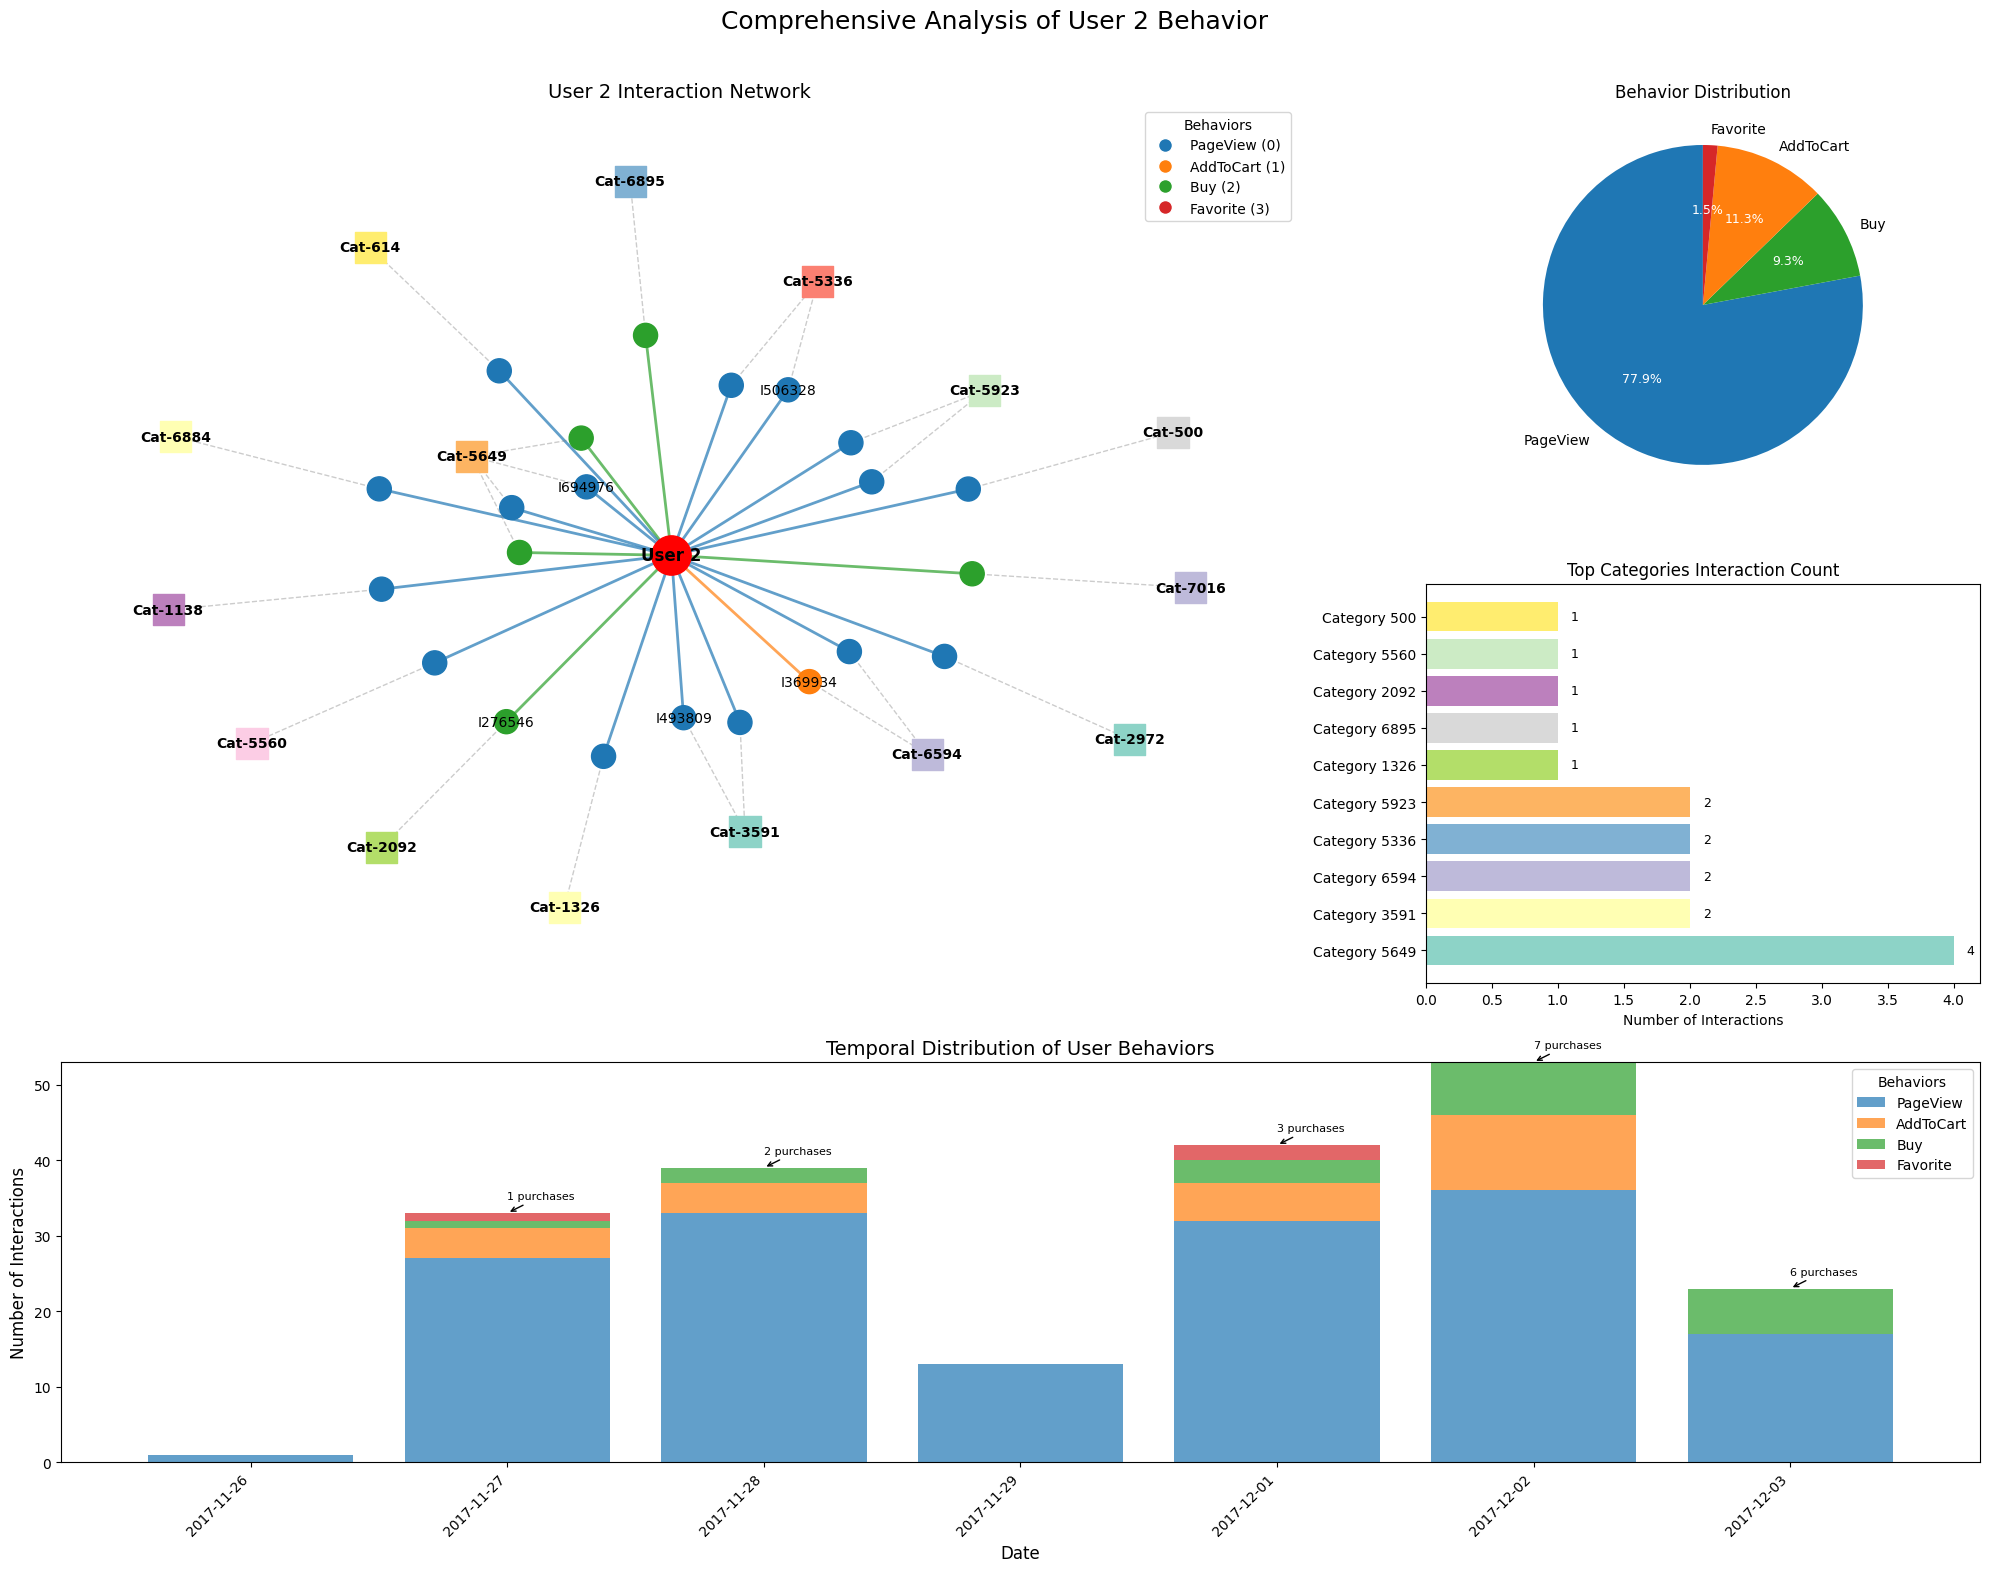

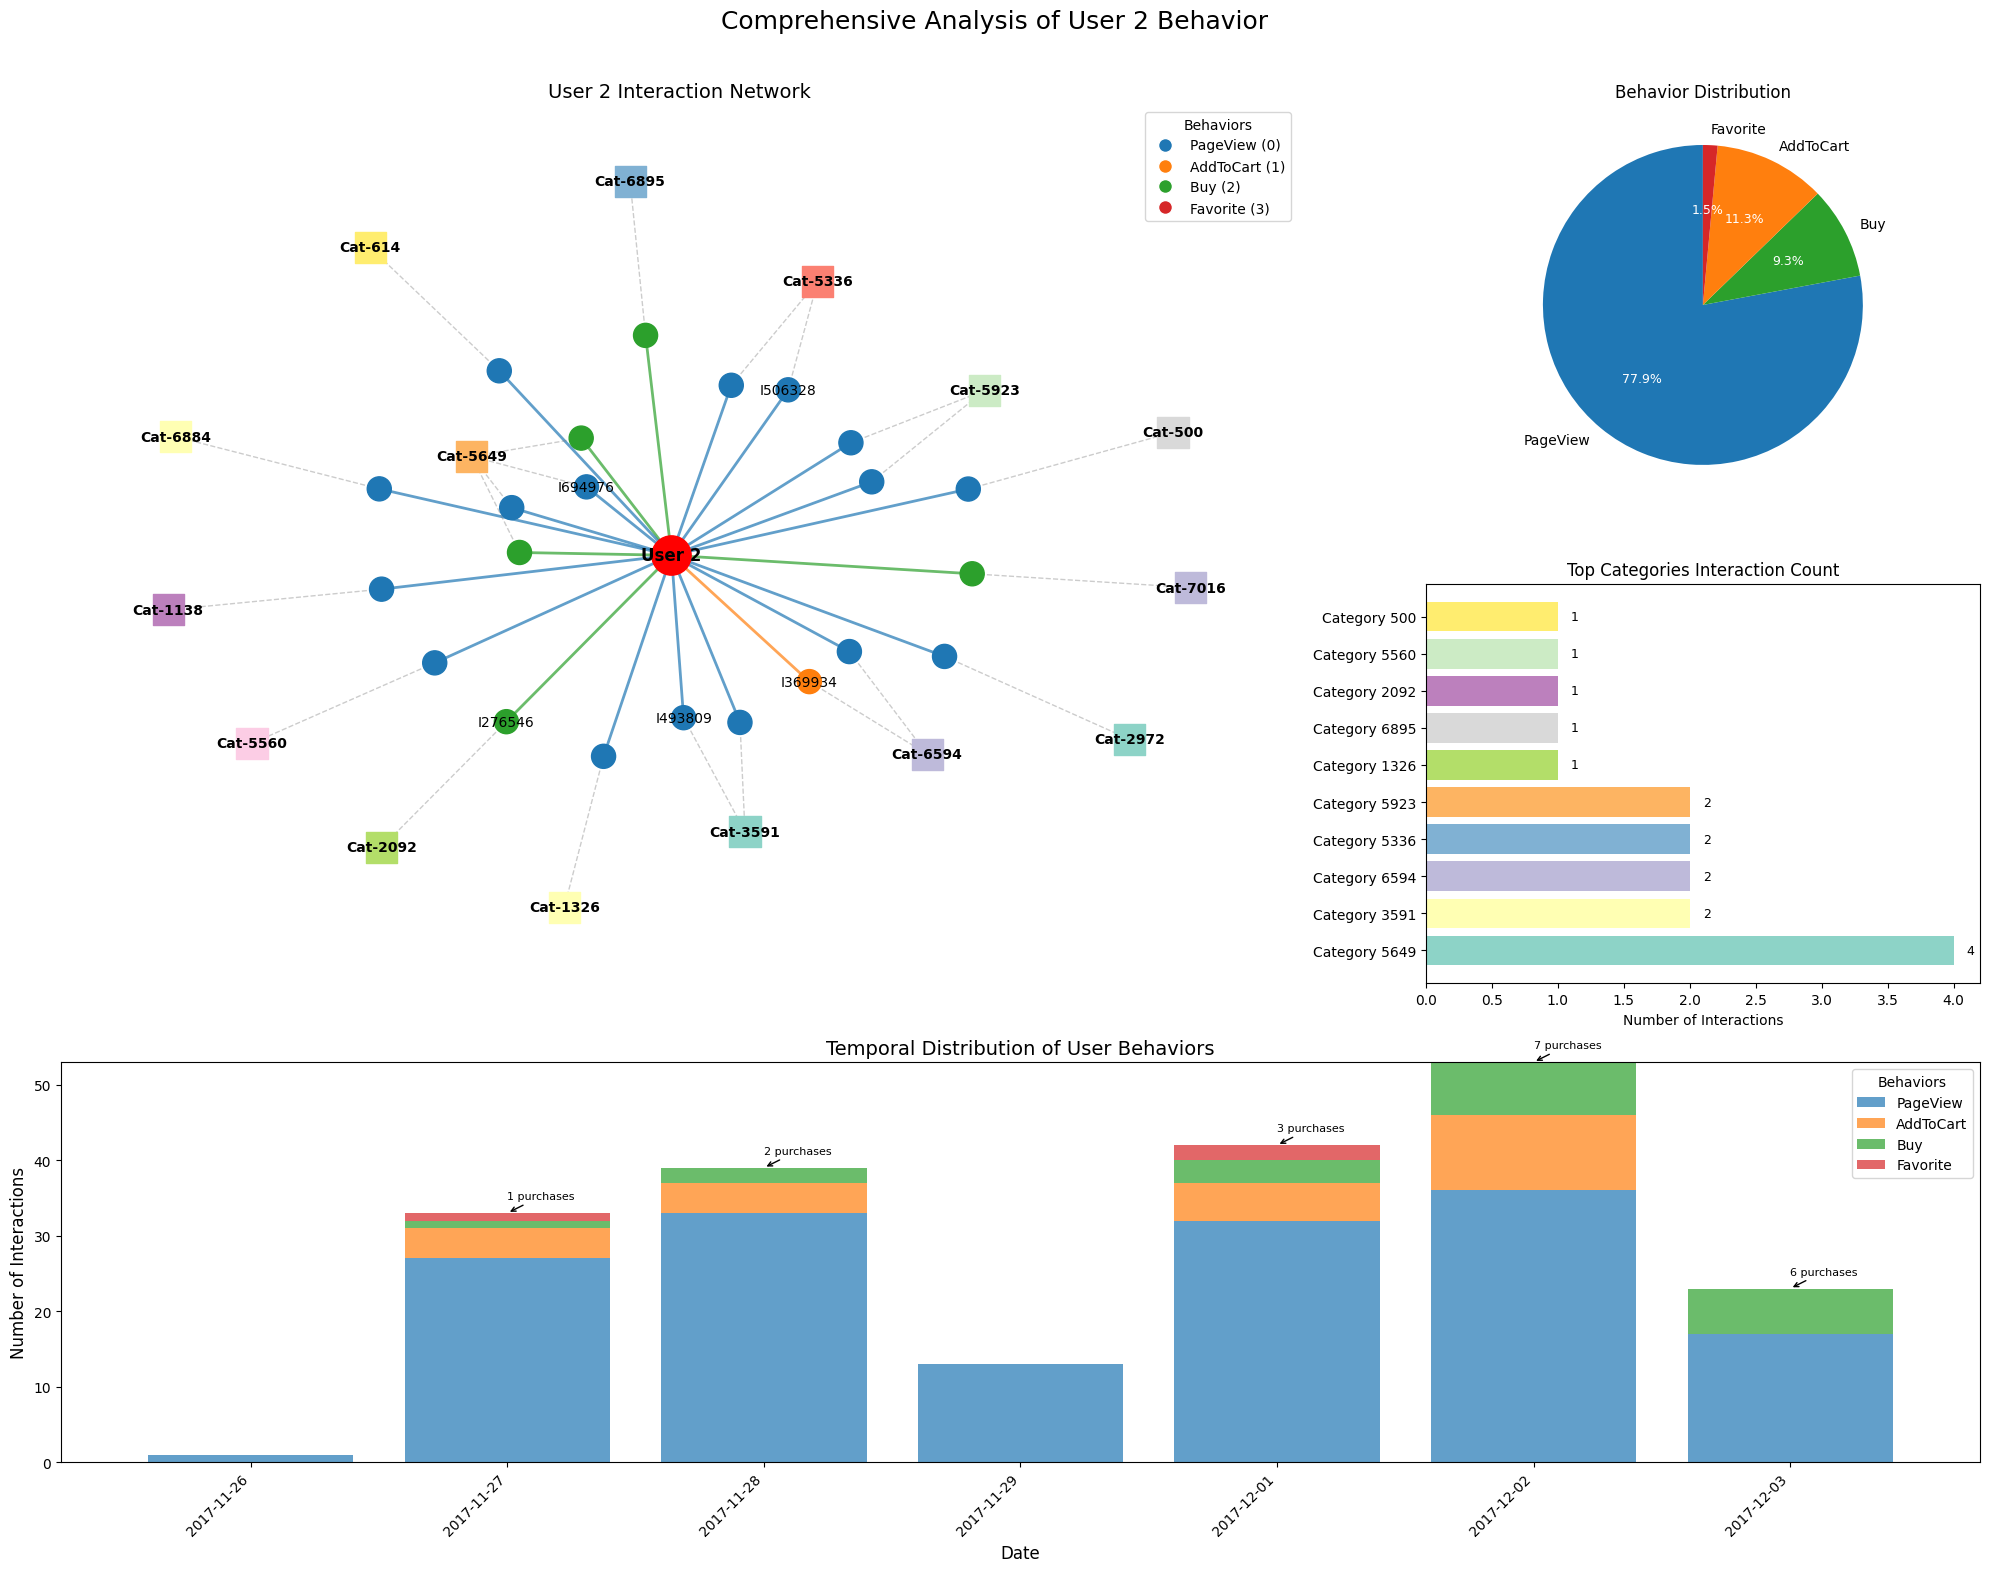

In [10]:
def visualize_comprehensive_user_behavior(data, behaviors_dict, categories_dict=None, user_id=None, max_items=30, time_window=None):
    """
    Creates a comprehensive visualization of user behavior including item categories, timestamps, and behavior types.
    
    Parameters:
    -----------
    data : HeteroData object
        The heterogeneous graph data containing user-item interactions and item-category relationships
    behaviors_dict : dict
        Dictionary mapping behavior names to their numeric codes
    categories_dict : dict, optional
        Dictionary mapping category names to their numeric codes
    user_id : int, optional
        User ID to focus on. If None, will select a user with diverse behaviors
    max_items : int, default=30
        Maximum number of items to display per visualization
    time_window : tuple, optional
        (start_timestamp, end_timestamp) to filter interactions by time
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    import torch
    import random
    import numpy as np
    from matplotlib.colors import to_rgba
    from matplotlib.cm import get_cmap
    import matplotlib.dates as mdates
    from datetime import datetime
    
    # Debug: Print all node and edge types
    print("Node types:", data.node_types)
    print("Edge types:", data.edge_types)
    
    # Invert the behavior dictionary for displaying names
    behavior_names = {v: k for k, v in behaviors_dict.items()}
    
    # Invert the category dictionary if provided
    category_names = {}
    if categories_dict:
        category_names = {v: k for k, v in categories_dict.items()}
    
    # Helper function to convert timestamp to datetime
    def timestamp_to_datetime(ts):
        return datetime.fromtimestamp(ts)
    
    # Check if category data exists and how it's structured
    has_category_data = False
    category_edge_type = None
    
    # Check for different possible representations of category data
    if 'category' in data.node_types:
        # Check all possible edge types that might connect items and categories
        for edge_type in data.edge_types:
            if len(edge_type) == 3:  # Check for 3-tuple edge types (src, rel, dst)
                if edge_type[0] == 'item' and edge_type[2] == 'category':
                    has_category_data = True
                    category_edge_type = edge_type
                    print(f"Found category data as edges: {edge_type}")
                    break
                elif edge_type[0] == 'category' and edge_type[2] == 'item':
                    has_category_data = True
                    category_edge_type = edge_type
                    print(f"Found category data as edges: {edge_type}")
                    break
    
    # If category data wasn't found but categories_dict was provided, create a warning
    if not has_category_data and categories_dict:
        print("Warning: Category dictionary provided but no category edges found in the graph structure.")
    
    # Find the user-item edge type
    user_item_edge_type = None
    for edge_type in data.edge_types:
        if len(edge_type) == 3 and edge_type[0] == 'user' and edge_type[2] == 'item':
            user_item_edge_type = edge_type
            print(f"Found user-item edge type: {edge_type}")
            break
    
    if user_item_edge_type is None:
        raise ValueError("Could not find user-item edge type in the graph")
    
    # If no user_id is provided, find a user with diverse behavior
    if user_id is None:
        user_candidates = []
        all_users = torch.unique(data[user_item_edge_type].edge_index[0]).tolist()
        
        # For each user, count the number of different behaviors
        for user in all_users[:1000]:  # Check first 1000 users for efficiency
            behavior_counts = {}
            
            user_mask = (data[user_item_edge_type].edge_index[0] == user)
            if user_mask.sum() < 10:  # Skip users with few interactions
                continue
                
            # Count behaviors
            behaviors = data[user_item_edge_type].behavior[user_mask]
            for b in behaviors:
                b_code = b.item()
                behavior_counts[b_code] = behavior_counts.get(b_code, 0) + 1
            
            # Count unique items for this user
            items = data[user_item_edge_type].edge_index[1, user_mask]
            num_unique_items = len(torch.unique(items))
            
            # Check if user has multiple behaviors and a decent number of items
            if len(behavior_counts) >= min(3, len(behaviors_dict)) and num_unique_items >= 10:
                user_candidates.append((user, len(behavior_counts), num_unique_items))
                if len(user_candidates) >= 5:  # Stop after finding 5 candidates
                    break
        
        if user_candidates:
            # Sort by number of behaviors and unique items
            user_candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
            user_id = user_candidates[0][0]
            print(f"Selected user ID: {user_id} (has {user_candidates[0][1]} behavior types and {user_candidates[0][2]} unique items)")
        else:
            # If no suitable user found, pick one with the most interactions
            interaction_counts = {}
            for user in all_users[:1000]:
                user_mask = (data[user_item_edge_type].edge_index[0] == user)
                interaction_counts[user] = user_mask.sum().item()
            
            user_id = max(interaction_counts, key=interaction_counts.get)
            print(f"No ideal user found. Selected user ID: {user_id} with {interaction_counts[user_id]} interactions")
    
    # Filter interactions for the selected user
    user_mask = (data[user_item_edge_type].edge_index[0] == user_id)
    user_edges = data[user_item_edge_type].edge_index[:, user_mask]
    user_behaviors = data[user_item_edge_type].behavior[user_mask]
    
    # Extract timestamps if available
    has_timestamps = False
    user_timestamps = None
    
    # Check for different possible locations/names of timestamp data
    possible_timestamp_attrs = ['timestamp', 'time', 'timestamps', 'edge_time']
    
    for attr in possible_timestamp_attrs:
        if hasattr(data[user_item_edge_type], attr):
            has_timestamps = True
            user_timestamps = getattr(data[user_item_edge_type], attr)[user_mask]
            print(f"Found timestamp data in {user_item_edge_type}.{attr}")
            break
    
    # Apply time window filtering if specified and timestamps are available
    if has_timestamps and time_window:
        start_time, end_time = time_window
        time_mask = (user_timestamps >= start_time) & (user_timestamps <= end_time)
        user_edges = user_edges[:, time_mask]
        user_behaviors = user_behaviors[time_mask]
        user_timestamps = user_timestamps[time_mask]
    
    # Create a comprehensive figure for visualization
    fig = plt.figure(figsize=(20, 16))
    
    # Create a grid layout
    gs = fig.add_gridspec(3, 3)
    
    # 1. Network visualization (user-item-category network)
    ax_network = fig.add_subplot(gs[0:2, 0:2])
    
    # Create NetworkX graph for the network visualization
    G = nx.Graph()
    
    # Add the central user node
    user_node = f"U{user_id}"
    G.add_node(user_node, type='user')
    
    # Dictionary to track item categories
    item_categories = {}
    
    # Add edges to items
    max_display_items = min(max_items, user_edges.shape[1])
    
    # Sort by timestamp if available
    if has_timestamps:
        # Sort indices by timestamp
        sorted_indices = torch.argsort(user_timestamps)
        # Take the most recent interactions up to max_display_items
        display_indices = sorted_indices[-max_display_items:]
    else:
        # Random sampling
        all_indices = list(range(user_edges.shape[1]))
        display_indices = torch.tensor(random.sample(all_indices, min(max_display_items, len(all_indices))))
    
    # Prepare node attributes
    node_types = {user_node: 'user'}
    node_behaviors = {}
    node_timestamps = {}
    edge_behaviors = {}
    edge_timestamps = {}
    
    # Keep track of unique items for category lookup
    unique_items = set()
    
    # Add selected items to the graph
    for idx in display_indices:
        i = idx.item()
        item_id = user_edges[1, i].item()
        item_node = f"I{item_id}"
        behavior = user_behaviors[i].item()
        
        # Add the item node if not already in graph
        if item_node not in G:
            G.add_node(item_node, type='item')
            node_types[item_node] = 'item'
            unique_items.add(item_id)
        
        # Add edge with behavior information
        edge_key = (user_node, item_node)
        G.add_edge(*edge_key)
        edge_behaviors[edge_key] = behavior
        if has_timestamps:
            timestamp = user_timestamps[i].item()
            edge_timestamps[edge_key] = timestamp
            node_timestamps[item_node] = timestamp
    
    # Add category information if we have item-category edges
    if has_category_data and category_edge_type:
        # Get the edge indices for item-category connections
        item_cat_edges = data[category_edge_type].edge_index
        
        # Find categories for each item in our graph
        for item_id in unique_items:
            if category_edge_type[0] == 'item' and category_edge_type[2] == 'category':
                # Find where this item is in the source (index 0)
                item_indices = (item_cat_edges[0] == item_id).nonzero(as_tuple=True)[0]
                
                if len(item_indices) > 0:
                    # Get the corresponding category IDs
                    for idx in item_indices:
                        cat_id = item_cat_edges[1, idx].item()
                        item_node = f"I{item_id}"
                        item_categories[item_node] = cat_id
            else:  # ('category', ..., 'item')
                # Find where this item is in the target (index 1)
                item_indices = (item_cat_edges[1] == item_id).nonzero(as_tuple=True)[0]
                
                if len(item_indices) > 0:
                    # Get the corresponding category IDs
                    for idx in item_indices:
                        cat_id = item_cat_edges[0, idx].item()
                        item_node = f"I{item_id}"
                        item_categories[item_node] = cat_id
    
    # Add category nodes and connect them to items
    if has_category_data and item_categories:
        for item_node, cat_id in item_categories.items():
            cat_node = f"C{cat_id}"
            if cat_node not in G:
                G.add_node(cat_node, type='category')
                node_types[cat_node] = 'category'
            G.add_edge(item_node, cat_node)
    
    # Define node colors by type
    node_colors = []
    node_sizes = []
    
    # Use a spring layout with the user at the center
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)
    pos[user_node] = np.array([0, 0])  # Center the user
    
    # Separate nodes by type
    user_nodes = [n for n in G.nodes() if node_types.get(n) == 'user']
    item_nodes = [n for n in G.nodes() if node_types.get(n) == 'item']
    category_nodes = [n for n in G.nodes() if node_types.get(n) == 'category']
    
    # Set up behavior color mapping
    behavior_cmap = get_cmap('tab10')
    behavior_colors = {code: behavior_cmap(i % 10) for i, code in enumerate(behaviors_dict.values())}
    
    # Draw nodes by type
    nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='red', 
                          node_size=800, label='User', ax=ax_network)
    
    # Color items by their most recent behavior
    item_colors = []
    for node in item_nodes:
        behavior = edge_behaviors.get((user_node, node), 0)
        item_colors.append(behavior_colors.get(behavior, 'gray'))
    
    nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_color=item_colors, 
                          node_size=300, label='Items', ax=ax_network)
    
    # Draw category nodes if available
    if category_nodes:
        category_cmap = get_cmap('Set3')
        category_colors = [category_cmap(i % 12) for i in range(len(category_nodes))]
        nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color=category_colors, 
                              node_size=500, node_shape='s', label='Categories', ax=ax_network)
    
    # Draw edges with different styles based on connection type and behaviors
    user_item_edges = [(u, v) for u, v in G.edges() if 
                       (u.startswith("U") and v.startswith("I")) or 
                       (v.startswith("U") and u.startswith("I"))]
    
    item_category_edges = [(u, v) for u, v in G.edges() if 
                          (u.startswith("I") and v.startswith("C")) or 
                          (v.startswith("I") and u.startswith("C"))]
    
    # Draw edges colored by behavior
    for edge in user_item_edges:
        behavior = edge_behaviors.get(edge, 0)
        color = behavior_colors.get(behavior, 'gray')
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=2.0, alpha=0.7, 
                              edge_color=[color], ax=ax_network)
    
    # Draw category connections
    nx.draw_networkx_edges(G, pos, edgelist=item_category_edges, width=1.0, alpha=0.4, 
                          edge_color='gray', style='dashed', ax=ax_network)
    
    # Add labels
    nx.draw_networkx_labels(G, pos, {user_node: f"User {user_id}"}, font_size=12, 
                           font_weight='bold', ax=ax_network)
    
    # Add a few item labels to prevent clutter
    if item_nodes:
        item_labels = {node: node for node in random.sample(item_nodes, min(5, len(item_nodes)))}
        nx.draw_networkx_labels(G, pos, item_labels, font_size=10, ax=ax_network)
    
    # Add category labels
    if category_nodes:
        if categories_dict:
            category_labels = {f"C{cat_id}": category_names.get(cat_id, f"Cat-{cat_id}") 
                             for cat_id in set(item_categories.values()) if cat_id >= 0}
        else:
            category_labels = {node: node for node in category_nodes}
            
        nx.draw_networkx_labels(G, pos, category_labels, font_size=10, font_weight='bold', ax=ax_network)
    
    # Add a legend for behaviors
    behavior_patches = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=behavior_colors[code], markersize=10, 
                                 label=f"{name} ({code})") 
                      for name, code in behaviors_dict.items()]
    
    ax_network.legend(handles=behavior_patches, loc='upper right', title="Behaviors")
    ax_network.set_title(f"User {user_id} Interaction Network", fontsize=14)
    ax_network.axis('off')
    
    # 2. Behavior Distribution Pie Chart
    ax_pie = fig.add_subplot(gs[0, 2])
    
    behavior_counts = {}
    for b in user_behaviors:
        b_code = b.item()
        behavior_counts[b_code] = behavior_counts.get(b_code, 0) + 1
    
    # Prepare data for pie chart
    pie_labels = [behavior_names.get(code, f"Behavior {code}") for code in behavior_counts.keys()]
    pie_values = list(behavior_counts.values())
    pie_colors = [behavior_colors.get(code, 'gray') for code in behavior_counts.keys()]
    
    # Create pie chart
    wedges, texts, autotexts = ax_pie.pie(
        pie_values, 
        labels=pie_labels, 
        autopct='%1.1f%%',
        colors=pie_colors,
        startangle=90
    )
    for text in texts:
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_fontsize(9)
        autotext.set_color('white')
    
    ax_pie.set_title("Behavior Distribution", fontsize=12)
    
    # 3. Category Distribution Bar Chart (if available)
    ax_categories = fig.add_subplot(gs[1, 2])
    
    # Try to create the category chart if we have category information
    if has_category_data and len(item_categories) > 0:
        category_counts = {}
        # Count categories for this user's interactions
        for item_node, cat_id in item_categories.items():
            category_counts[cat_id] = category_counts.get(cat_id, 0) + 1
        
        if category_counts:
            # Sort categories by count
            sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
            cat_ids, cat_counts = zip(*sorted_categories[:10])  # Top 10 categories
            
            if categories_dict:
                cat_names = [category_names.get(cat_id, f"Category {cat_id}") for cat_id in cat_ids]
            else:
                cat_names = [f"Category {cat_id}" for cat_id in cat_ids]
            
            # Create horizontal bar chart
            bars = ax_categories.barh(cat_names, cat_counts, color=category_cmap(np.linspace(0, 1, len(cat_names))))
            
            # Add count values at the end of each bar
            for i, (count, bar) in enumerate(zip(cat_counts, bars)):
                ax_categories.text(count + 0.1, bar.get_y() + bar.get_height()/2, str(count), 
                                 va='center', fontsize=9)
            
            ax_categories.set_title("Top Categories Interaction Count", fontsize=12)
            ax_categories.set_xlabel("Number of Interactions")
        else:
            ax_categories.text(0.5, 0.5, "No category counts available for this user", 
                             horizontalalignment='center', verticalalignment='center', fontsize=12)
            ax_categories.axis('off')
    else:
        ax_categories.text(0.5, 0.5, "Category data not available", 
                         horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax_categories.axis('off')
    
    # 4. Temporal Analysis (if timestamps available)
    ax_temporal = fig.add_subplot(gs[2, :])
    
    if has_timestamps:
        # Convert to datetime objects
        timestamps = user_timestamps.numpy()
        dates = [timestamp_to_datetime(ts) for ts in timestamps]
        behaviors = user_behaviors.numpy()
        
        # Sort by timestamp
        sorted_indices = np.argsort(timestamps)
        sorted_dates = [dates[i] for i in sorted_indices]
        sorted_behaviors = [behaviors[i] for i in sorted_indices]
        
        # Count interactions by date and behavior
        date_behavior_counts = {}
        for date, behavior in zip(sorted_dates, sorted_behaviors):
            date_key = date.strftime('%Y-%m-%d')
            if date_key not in date_behavior_counts:
                date_behavior_counts[date_key] = {}
            
            b_code = behavior
            date_behavior_counts[date_key][b_code] = date_behavior_counts[date_key].get(b_code, 0) + 1
        
        # Sort dates
        sorted_dates = sorted(date_behavior_counts.keys())
        
        # Prepare data for stacked bar chart
        date_labels = sorted_dates
        behaviors_by_date = {code: [] for code in behaviors_dict.values()}
        
        for date in date_labels:
            for code in behaviors_dict.values():
                behaviors_by_date[code].append(date_behavior_counts[date].get(code, 0))
        
        # Create stacked bar chart
        bottom = np.zeros(len(date_labels))
        for code, counts in behaviors_by_date.items():
            if sum(counts) > 0:  # Only plot behaviors that occur
                ax_temporal.bar(date_labels, counts, bottom=bottom, 
                              label=behavior_names.get(code, f"Behavior {code}"),
                              color=behavior_colors.get(code, 'gray'), alpha=0.7)
                bottom += np.array(counts)
        
        # Formatting
        ax_temporal.set_title("Temporal Distribution of User Behaviors", fontsize=14)
        ax_temporal.set_xlabel("Date", fontsize=12)
        ax_temporal.set_ylabel("Number of Interactions", fontsize=12)
        
        # Rotate date labels for better readability
        plt.setp(ax_temporal.get_xticklabels(), rotation=45, ha='right')
        
        # Add legend
        ax_temporal.legend(title="Behaviors", loc='upper right')
        
        # Add annotations for important points (e.g., purchase events)
        purchase_code = behaviors_dict.get('Buy', -1)
        if purchase_code != -1:
            for i, date in enumerate(date_labels):
                purchase_count = behaviors_by_date[purchase_code][i]
                if purchase_count > 0:
                    y_pos = sum(behaviors_by_date[code][i] for code in behaviors_dict.values())
                    ax_temporal.annotate(f"{purchase_count} purchases", 
                                      xy=(i, y_pos), 
                                      xytext=(0, 10),
                                      textcoords="offset points",
                                      arrowprops=dict(arrowstyle='->', color='black'),
                                      fontsize=8)
    else:
        ax_temporal.text(0.5, 0.5, "Timestamp data not available", 
                       horizontalalignment='center', verticalalignment='center', fontsize=14)
        ax_temporal.axis('off')
    
    # Add super title
    plt.suptitle(f"Comprehensive Analysis of User {user_id} Behavior", fontsize=18, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    # Save the figure
    plt.savefig(f'user_{user_id}_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig


# Example usage of the function with category dictionary
behavior_dict = {'PageView': 0, 'AddToCart': 1, 'Buy': 2, 'Favorite': 3}

# You can define your category dictionary like this:
categories_dict = {
    'Electronics': 0,
    'Clothing': 1, 
    'Home': 2, 
    'Books': 3, 
    'Beauty': 4, 
    'Sports': 5
    # Add more categories as needed
}

# Run the visualization
visualize_comprehensive_user_behavior(data, behavior_dict, categories_dict, max_items=50)